# Content-Aware Image Retargeting
Reduce the width of images (`Baby.png`, `Diana.png`, `Snowman.png`) by `seams_number` columns using Seam Carving, implemented from scratch. Optionally use depth/saliency maps or other energy functions. Visualize seams if enabled.

In [109]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#For show plot window outside of notebook
%matplotlib tk

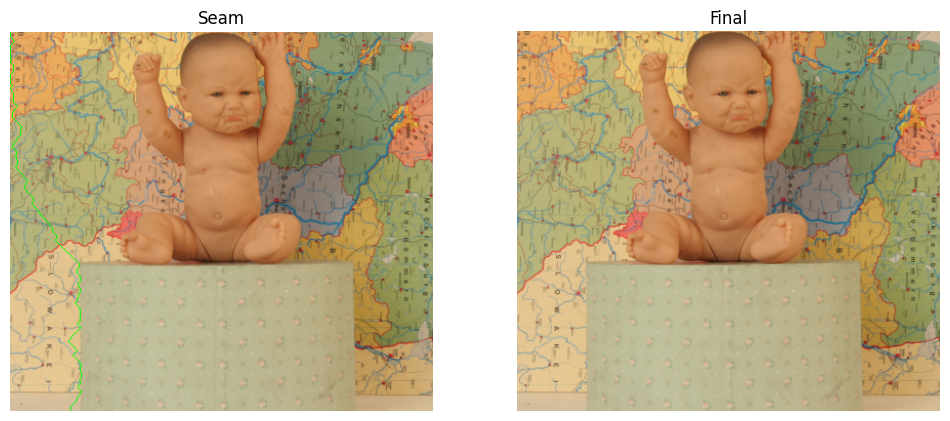

In [ ]:
def remove_seam_from_image(seam:list[int],image:np.ndarray,maps:list[np.ndarray]|None=None,visualize=False):
    """Remove a seam from image and maps

    Args:
        seam: List of seam indexes from top to bottom.
        image: Input image (H, W, 3) as float32 in [0, 1].
        maps: Optional list of 2D maps as float32 in [0, 1].
        visualize: If True, display seam and resized image.
    
    Returns:
        image_with_seam: Image (H, W, 3) as float32 in [0, 1] with green seam.
        removed_seam_image: Resized Image (H, W, 3) as float32 in [0, 1].
        removed_seam_maps: Resized maps if input is given.
    """

    #Save shape of image
    h,w,c=image.shape

    #Base image with width: w-1
    removed_seam_image=np.zeros((h,w-1,c),dtype=np.float32)

    #Base maps with same size
    if maps is not None:
        removed_seam_maps=[]
        for m in maps:
            removed_seam_maps.append(np.zeros((h,w-1),dtype=np.float32))

    #Copy of image to add graan seam
    image_with_seam=image.copy()

    #Image loop from top to bottom
    for i in range(h):
        #Index of seam pixel
        j=seam[i]

        #Remove pixel from image and maps
        removed_seam_image[i]=np.delete(image[i],j,0)
        if maps is not None:
            for rm,m in zip(removed_seam_maps,maps):
                rm[i]=np.delete(m[i],j,0)

        #Change seam pixel to green
        image_with_seam[i,j]=np.array([0,1,0]).astype(np.float32)
    
    #Show seam and final image
    if visualize:
        fig,axes=plt.subplots(1,2,figsize=(12,6))
        axes[0].imshow(cv2.cvtColor(image_with_seam,cv2.COLOR_BGR2RGB))
        axes[0].set_title("Seam")
        axes[0].axis("off")
        axes[1].imshow(cv2.cvtColor(removed_seam_image,cv2.COLOR_BGR2RGB))
        axes[1].set_title("Final")
        axes[1].axis("off")
        plt.show()

    #Two type of return based on input
    if maps is not None:
        return image_with_seam,removed_seam_image,removed_seam_maps
    return image_with_seam,removed_seam_image

In [15]:
def find_min_energy_seam(matrix:np.ndarray):
    """Find min energy seam as list of seam indexes from top to bottom

    Args:
        matrix: 2D top to bottom energy matrix as float64.
    
    Returns:
        seam: List of seam indexes from top to bottom.
        seam_energy: Total energy of seam.
    """

    #Save matrix size
    h,w=matrix.shape

    #Seam indexes list
    seam=[]

    #Choose minimum seam from last row
    j=np.argmin(matrix[-1])
    seam.append(j)
    seam_energy=matrix[-1,j]

    #Find seam from bottom to top
    for i in range(h-2,-1,-1):
        j=seam[-1]
        #First and last columns have two option to continue seam
        if j==0:
            seam.append(j+np.argmin(matrix[i,j:j+2]))
        elif j==w-1:
            seam.append(j-1+np.argmin(matrix[i,j-1:j+1]))
        else:
            seam.append(j-1+np.argmin(matrix[i,j-1:j+2]))
    
    #Seam indexes from top to bottom
    seam.reverse()

    #Return seam indexes and its energy
    return seam,seam_energy

([np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(2),
  np.int64(3),
  np.int64(3),
  np.int64(4),
  np.int64(3),
  np.int64(2),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(2),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(2),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(2),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(2),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64(3),
  np.int64

In [14]:
def calculate_energy_matrix(map:np.ndarray):
    """Calculate energy matrix from top to bottom

    Args:
        map: 2D map as float32 in [0, 1].
        visualize: If True, display all maps and resualt.
    
    Returns:
        energy_matrix: 2D top to bottom energy matrix as float64.
    """

    #Copy of map as float64 and save its shape
    matrix=map.copy().astype(np.float64)
    h,w=matrix.shape

    #Calculate from row 2
    for i in range(1,h):
        for j in range(w):
            #First and last columns have two option
            if j==0:
                matrix[i,j]=min(matrix[i-1,j],matrix[i-1,j+1])+matrix[i,j]
            elif j==w-1:
                matrix[i,j]=min(matrix[i-1,j-1],matrix[i-1,j])+matrix[i,j]
            else:
                matrix[i,j]=min(matrix[i-1,j-1],matrix[i-1,j],matrix[i-1,j+1])+matrix[i,j]

    return matrix

array([[  0.19485293,   0.20145723,   0.20733489, ...,   0.26713675,
          0.26685232,   0.26544118],
       [  0.38979007,   0.44579299,   0.47191796, ...,   0.53473404,
          0.53235152,   0.53192076],
       [  0.60207365,   0.69188736,   0.72985922, ...,   0.80135304,
          0.80037546,   0.7988221 ],
       ...,
       [ 84.48898964,  84.37092111,  84.34613492, ..., 101.65148565,
        101.6905821 , 101.69694343],
       [ 84.72178331,  84.69767226,  84.68117106, ..., 102.0173972 ,
        102.02844822, 102.06788224],
       [ 85.0552703 ,  85.03944424,  85.03886226, ..., 102.39286327,
        102.39984259, 102.41055605]], shape=(370, 413))

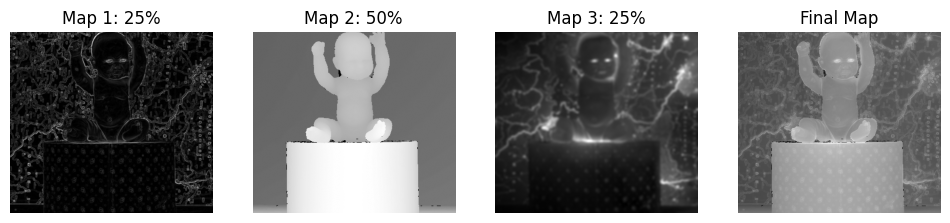

In [ ]:
def wheighted_final_map(maps:list[np.ndarray],wheights:list[float],visualize=False):
    """Generate final energy map from all maps with custom wheights

    Args:
        maps: Tuple of 2D maps as float32 in [0, 1].
        wheights: Weight of each map in final map with sum=1.
        visualize: If True, display all maps and resualt.
    
    Returns:
        wmap: Final 2D energy map as float32 in [0, 1].
    """

    #Number of input maps
    n=len(maps)

    #Show all maps and wheights and final map
    if visualize:
        fig,axes=plt.subplots(1,n+1,figsize=((n+1)*3,4))

    #Base of final map
    wmap=np.zeros_like(maps[0])

    #Loop in maps
    for i in range(n):
        #Add each map to plot
        if visualize:
            axes[i].imshow(maps[i],cmap="gray")
            axes[i].set_title(f"Map {i+1}: {int(wheights[i]*100)}%")
            axes[i].axis("off")

        #Add each map to final map with wheight
        wmap+=maps[i]/np.max(maps[i])*wheights[i]
    
    #Add final map to plot and show it
    if visualize:
        axes[n].imshow(wmap,cmap="gray")
        axes[n].set_title("Final Map")
        axes[n].axis("off")
        plt.show()

    #Return final map
    return wmap

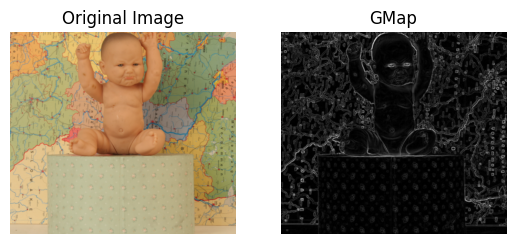

array([[0.00000000e+00, 6.33724928e-02, 1.19772434e-01, ...,
        6.86275959e-03, 4.13334370e-03, 0.00000000e+00],
       [8.08000565e-04, 5.28784156e-01, 7.53325224e-01, ...,
        4.60374355e-03, 4.69022989e-03, 5.56707382e-04],
       [1.57850742e-01, 1.01967072e+00, 8.46650958e-01, ...,
        1.53487921e-02, 1.01016164e-02, 4.60386276e-03],
       ...,
       [1.01017952e-02, 1.28703713e-02, 6.39218092e-03, ...,
        1.28703713e-02, 8.18061829e-03, 3.57651711e-03],
       [5.92160225e-03, 1.24000311e-02, 1.33411884e-02, ...,
        1.83687210e-02, 2.11843848e-02, 2.44235992e-02],
       [0.00000000e+00, 6.47842884e-03, 8.94069672e-04, ...,
        1.05255842e-02, 3.23927402e-03, 0.00000000e+00]],
      shape=(370, 413), dtype=float32)

In [10]:
def generate_GMap(image:np.ndarray,visualize=False):
    """Generate gradient energy map of image

    Args:
        image: Input image (H, W, 3) as float32 in [0, 1].
        visualize: If True, display GMap.
    
    Returns:
        gmap: Gradient energy map of image
    """

    #Remove colors
    gmap=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

    #Sobel filters to show edges
    sobel_x=cv2.Sobel(gmap,cv2.CV_32F,1,0,ksize=3)
    sobel_y=cv2.Sobel(gmap,cv2.CV_32F,0,1,ksize=3)

    #Calculate gmap
    gmap=np.abs(sobel_x)+np.abs(sobel_y)
    
    #Show plot of image and its gmap
    if visualize:
        fig,axes=plt.subplots(1,2)
        axes[0].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
        axes[0].set_title("Original Image")
        axes[0].axis("off")
        axes[1].imshow(gmap,cmap="gray")
        axes[1].set_title("GMap")
        axes[1].axis("off")
        plt.show()

    #Return GMap
    return gmap

In [ ]:
def seam_carving(image,seams_number,depth_map=None,saliency_map=None,visualize=False):
    """Perform Seam Carving to reduce image width by seams_number columns.
    
    Args:
        image: Input image (H, W, 3) as float32 in [0, 1].
        seams_number: Number of vertical seams to remove.
        depth_map: Optional depth map (H, W) as float32.
        saliency_map: Optional saliency map (H, W) as float32.
        visualize: If True, display seams during processing.
    
    Returns:
        resized_image: Image with reduced width.
        seam_energies: List of cumulative energies of removed seams.
    """
    # TODO: Implement Seam Carving from scratch
    # 1. Compute energy map (e.g., gradient, depth, or saliency-based)
    # 2. Find lowest-energy vertical seam using dynamic programming
    # 3. Remove seam and update image
    # 4. Repeat for seams_number iterations
    # 5. Visualize seams if flag enabled
    # 6. Log seam energies
    
    #Copy of image for first seam removal
    final_image=image.copy()

    #List of seam energies for logging
    seam_energies=[]

    #List of maps and custom wheights for each list of maps
    #maps[0]:Calculated GMap
    maps=[None,]
    if depth_map is not None and saliency_map is not None:
        maps.append(depth_map)
        maps.append(saliency_map)
        wheights=[0.25,0.5,0.25]
    elif depth_map is not None:
        maps.append(depth_map)
        wheights=[0.40,0.60]
    elif saliency_map is not None:
        maps.append(saliency_map)
        wheights=[0.5,0.5]
    else:
        wheights=[1.0,]
    
    #Initialize visualizing
    if visualize:
            plt.ion()
            fig,ax=plt.subplots()
            ax.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
            ax.axis("off")
            ax.set_title("Let's Go!!!")
            plt.pause(1)

    #Loop of seam removal
    for n in range(seams_number):
        #Generate GMap    
        maps[0]=generate_GMap(final_image)
        
        #Generate WMap from all maps
        wheighted_map=wheighted_final_map(maps,wheights)

        #Calculate energy matrix of map
        energy_matrix=calculate_energy_matrix(wheighted_map)

        #Find seam and log its energy
        seam,seam_energy=find_min_energy_seam(energy_matrix)
        seam_energies.append(f"Seam {n+1}: {seam_energy}")
        
        #Remove seam from image and maps and image with green seam
        if len(maps)==1:
            seam_image,final_image=remove_seam_from_image(seam,final_image)
        else:
            seam_image,final_image,maps[1:]=remove_seam_from_image(seam,final_image,maps[1:])

        #Show each seam removal
        if visualize:
            ax.clear()
            ax.imshow(cv2.cvtColor(seam_image,cv2.COLOR_BGR2RGB))
            ax.axis("off")
            ax.set_title(f"Remove seam {n+1}/{seams_number}")
            plt.pause(0.01)

    #Return image and seam logs
    return final_image,seam_energies

In [ ]:
#Load images and maps
def load_files(image_name):
    image_path = f"./images/{image_name}/{image_name}.png"
    image_dmap_path = f"./images/{image_name}/{image_name}_DMap.png"
    image_smap_path = f"./images/{image_name}/{image_name}_SMap.png"
    return image_path,image_dmap_path,image_smap_path

file_name="Baby"
# file_name="Diana"
# file_name="Snowman"
image_path,image_dmap_path,image_smap_path=load_files(file_name)

image=cv2.imread(image_path).astype(np.float32)/255.0
image_dmap=cv2.imread(image_dmap_path,cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0
image_smap=cv2.imread(image_smap_path,cv2.IMREAD_GRAYSCALE).astype(np.float32)/255.0

#Parameters
seams_number=200
visualize=True #If True, uncomment %matplotlib tk in first cell and restart to show animation

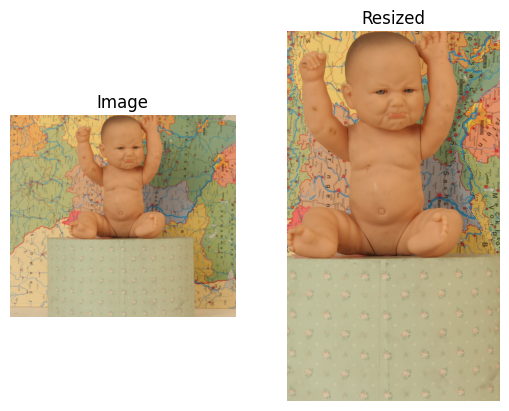

In [20]:
#Process images
image_resized,seam_energies=seam_carving(image,seams_number,image_dmap,image_smap,visualize)

#Save seam energies
with open(f"{file_name}_energy_log.txt","w") as f:
    f.write(f"{file_name} Seam Energies:\n" + "\n".join(map(str, seam_energies)) + "\n")

#Visualize results
fig,axes=plt.subplots(1,2)
axes[0].imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
axes[0].set_title("Image")
axes[0].axis("off")
axes[1].imshow(cv2.cvtColor(image_resized,cv2.COLOR_BGR2RGB))
axes[1].set_title("Resized")
axes[1].axis("off")
plt.show()

#Save resized images
cv2.imwrite(f"{file_name}_resized.png",(image_resized*255).astype(np.uint8));